In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import mglearn 
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix

# 데이터 EDA

### 데이터 불러오기

In [2]:
df = pd.read_csv('./data/final_dataset.csv', encoding='EUC-KR') # 각자 경로 따라 수정. 인코딩 필요없을수도있음

### 데이터 기초 정보 확인

In [3]:
df.shape  # 전체 900행으로 나타남

(14810, 16)

In [4]:
df.info() 
# 학점 ~ 봉사까지 전부 int나 float이 아닌 object인 것을 확인할 수 있음. 이는 점수 뒤에 붙은 조사 때문으로 보임
# 학점은 float, 나머지는 int로 변환할 필요가 있음

# 또한 14811이 아닌 열이 일부 관측됨. 지원분야, 학교, 전공, 자격증 분야에 대한 구체적 확인이 필요함

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14810 entries, 0 to 14809
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   기업명     14810 non-null  object
 1   지원분야    13779 non-null  object
 2   학교      14810 non-null  object
 3   전공      12563 non-null  object
 4   학점      14810 non-null  object
 5   토익      14810 non-null  object
 6   오픽      14810 non-null  object
 7   토스      14810 non-null  object
 8   자격증     14809 non-null  object
 9   연수      14810 non-null  object
 10  봉사      14810 non-null  object
 11  인턴      14810 non-null  object
 12  업종      14810 non-null  object
 13  업종분류    14810 non-null  int64 
 14  기업규모    14810 non-null  object
 15  규모분류    14810 non-null  int64 
dtypes: int64(2), object(14)
memory usage: 1.8+ MB


In [5]:
df.describe() # int 타입이 아닌 object 타입이라 제대로 값이 산출되지 않음

,업종분류,규모분류
count,14810.000000,14810.000000
mean,10.605334,2.145037
std,5.317740,1.137411
min,1.000000,1.000000
25%,7.000000,1.000000
50%,11.000000,2.000000
75%,14.000000,3.000000
max,19.000000,4.000000


In [6]:
df.isnull().sum() # 빈 행 갯수만큼 각 열에서 null값이 관측됨. 해당 데이터 결측치에 대한 전처리가 필요할 것으로 판단됨.

기업명        0
지원분야    1031
학교         0
전공      2247
학점         0
토익         0
오픽         0
토스         0
자격증        1
연수         0
봉사         0
인턴         0
업종         0
업종분류       0
기업규모       0
규모분류       0
dtype: int64

In [7]:
null_rows_2 = df[df['학교']=='고졸']
null_rows_2

,기업명,지원분야,학교,전공,학점,토익,오픽,토스,자격증,연수,봉사,인턴,업종,업종분류,기업규모,규모분류
9,아워홈,요리사,고졸,NaN,-,-,-,-,2개,-,-,-,음식료/호텔/리조트/여행,10,중견기업,2
16,21세기조선,생산직종사자,고졸,NaN,-,-,-,-,1개,-,-,-,자동차/기계/조선,12,중소기업,4
32,ADT캡스,회계담당자,고졸,NaN,-,-,-,-,4개,-,-,-,다업종기업/기타,3,중소기업,4
33,ADT캡스,설치·수리기사,고졸,NaN,-,-,-,-,1개,-,-,-,다업종기업/기타,3,중소기업,4
34,ADT캡스,시설관리자,고졸,NaN,-,-,-,-,2개,-,-,-,다업종기업/기타,3,중소기업,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14761,흥아해운,회계담당자,고졸,NaN,-,-,-,-,-,-,-,-,상사/유통/운송,7,중견기업,2
14766,흥아해운,인사담당자,고졸,NaN,-,-,-,-,4개,-,-,-,상사/유통/운송,7,중견기업,2
14792,희성촉매,생산직종사자,고졸,NaN,-,-,-,-,3개,-,-,-,자동차/기계/조선,12,중견기업,2
14796,희성촉매,생산직종사자,고졸,NaN,-,-,-,-,-,-,-,-,자동차/기계/조선,12,중견기업,2


### 데이터 타입 변경 및 기초 전처리

In [8]:
# 영어점수는 토익, 토익스피킹, 오픽중 하나만 따는 경향이 있음. 따라서 비어있는 경우가 많으므로 세 열을 하나로 합치는게 나을 것으로 보임
# 토익스피킹과 오픽 점수는 토익 점수로 환산이 가능함. 따라서 토익 점수 분류에 따라 토익스피킹과 오픽 점수를 변환함
eng = {'-' : 0, 'Lv1' : 100, 'Lv2' : 200, 'Lv3' : 300, 'Lv4' : 440, 'Lv5' : 600, 'Lv6' : 775, 'Lv7' : 915, 'Lv8' : 975,
       'Level 2' : 200, 'Level 4' : 440, 'Level 5' : 600, 'Level 6' : 775, 'Level 7' : 915, 'Level 8' : 975,
       'AL' : 975, 'AM' : 990, 'AH' : 990,
       'IL' : 440, 'IM': 570, 'IM1' : 570, 'IM2' : 745, 'IM3' : 845, '13' : 845, 'IH' : 915,
       'NL' : 100, 'NH' : 300, 'M1' : 570, 'M2' : 745}
df = df.replace(to_replace=eng)

In [9]:
df['토스'].unique()

array([0, 975, 775, '없음', 915, 440, 600, 845, 200, 990, 100, 300],
      dtype=object)

In [10]:
df.head()
# 확인결과 정상적으로 변환된 것을 알 수 있음. 
#단, 일부 열이 아닌 전체 열에 변환과정을 진행한 것으로 타 행에서 '-'가 0으로 변환되었을 수 있음
# 따라서 추후 시각화 과정에서 다른 열, 특히 회사명~전공 등 str 열에 0값이 나타나는지 확인이 필요함
# 특히 결측치가 확인되었었던 전공, 기업분류, 지원분야 열을 주의깊게 확인

,기업명,지원분야,학교,전공,학점,토익,오픽,토스,자격증,연수,봉사,인턴,업종,업종분류,기업규모,규모분류
0,아워홈,법인영업,지방4년제,중국어과,3.5,0,0,0,0,1회,0,0,음식료/호텔/리조트/여행,10,중견기업,2
1,아워홈,재무담당자,수도권4년제,중어중문과,3.57,900점,0,975,4개,2회,0,0,음식료/호텔/리조트/여행,10,중견기업,2
2,아워홈,바이오·제약연구원,대학원,화공생명공학과,4.19,800점,0,775,4개,1회,0,1회,음식료/호텔/리조트/여행,10,중견기업,2
3,아워홈,바이오·제약연구원,대학원,화공생명공학과,4.19,800점,0,775,4개,1회,0,1회,음식료/호텔/리조트/여행,10,중견기업,2
4,아워홈,온라인마케터,수도권4년제,문화경영학과,3.63,950점,0,775,1개,1회,3회,2회,음식료/호텔/리조트/여행,10,중견기업,2


In [11]:
# 숫자형 데이터에서 '점', '개', '회' 등을 떼어내는 코드
df['토익'] = df['토익'].str.extract(r'(\d+)')
df['자격증'] = df['자격증'].str.extract(r'(\d+)')
df['연수'] = df['연수'].str.extract(r'(\d+)')
df['인턴'] = df['인턴'].str.extract(r'(\d+)')
df['봉사'] = df['봉사'].str.extract(r'(\d+)')
df = df.fillna(0)
df = df.astype({'학점' : 'float', '토익':'int32', '자격증':'int32', '연수':'int32', '인턴':'int32', '봉사':'int32'})

In [12]:
df.info() 
# 정상적으로 데이터 타입이 변경되었음을 확인할 수 있음. 
#단, 아까 우려한 대로 결측치가 사라짐. 해당 결측치들에 0값이 들어갔을것으로 추측됨

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14810 entries, 0 to 14809
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   기업명     14810 non-null  object 
 1   지원분야    14810 non-null  object 
 2   학교      14810 non-null  object 
 3   전공      14810 non-null  object 
 4   학점      14810 non-null  float64
 5   토익      14810 non-null  int32  
 6   오픽      14810 non-null  object 
 7   토스      14810 non-null  object 
 8   자격증     14810 non-null  int32  
 9   연수      14810 non-null  int32  
 10  봉사      14810 non-null  int32  
 11  인턴      14810 non-null  int32  
 12  업종      14810 non-null  object 
 13  업종분류    14810 non-null  int64  
 14  기업규모    14810 non-null  object 
 15  규모분류    14810 non-null  int64  
dtypes: float64(1), int32(5), int64(2), object(8)
memory usage: 1.5+ MB


In [13]:
df.describe() 
# 연수, 인턴, 봉사는 상위 75%값도 눈에띄게 낮으며, 특히 외국어의 경우 상위 75%도 0을 기록함
# 분석에 필수적인 자료가 아닐것으로 판단되므로 제외하는것이 나을수도 있을것으로 판단됨

,학점,토익,자격증,연수,봉사,인턴,업종분류,규모분류
count,14810.000000,14810.000000,14810.000000,14810.000000,14810.000000,14810.000000,14810.000000,14810.000000
mean,3.367169,578.219514,1.447333,0.376165,0.560162,0.328089,10.605334,2.145037
std,1.101730,394.912070,1.674575,0.775032,1.174863,0.938259,5.317740,1.137411
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,3.390000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000
50%,3.670000,800.000000,1.000000,0.000000,0.000000,0.000000,11.000000,2.000000
75%,3.910000,880.000000,2.000000,1.000000,1.000000,0.000000,14.000000,3.000000
max,4.500000,990.000000,16.000000,14.000000,16.000000,11.000000,19.000000,4.000000


In [14]:
# 범주형 데이터 라벨 인코딩
# 사용할 열만 라벨 인코딩을 진행함
# 본 분석에서 기업명, 지원분야, 전공은 필요없을것으로 판단되므로 라벨인코딩 해야하는 학교와 전공중 학교만 하면 됨

df=df.drop(['기업명','지원분야','전공'],axis=1)

In [15]:
# object 열 [회사명, 기업분류, 시기, 지원분야, 대학, 계열, 전공] 
# 회사명은 추구 기업 규모와 합쳐져 y값에 들어갈 내용이므로 제외, 기업분류도 분류코드와 내용이 중복되므로 제외
# 지원분야는 고려하지 않을것이므로 제외 , 시기도 시계열분석을 진행하지 않을것이므로 제외
# 따라서 대학, 계열, 전공만 숫자형 데이터로 인코딩을 진행함

#df = df[df.학교 != 0]
lb = LabelEncoder()
df['학교'] = lb.fit_transform(df['학교'])

# label 인코딩과 원핫 인코딩중 무얼 사용할지도 생각해보기
# 라벨인코딩의 경우 단순히 라벨링해서 숫자 1부터 쭈루룩 달아주는건데 모델에 따라서 숫자가 높을수록 관련이 높다고 해석될 여지도 있음!

In [16]:
df.info() # 아까 전공계열에 있던 결측치 갯수만큼 전체 열의 행이 감소한 것을 확인해볼 수 있다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14810 entries, 0 to 14809
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   학교      14810 non-null  int32  
 1   학점      14810 non-null  float64
 2   토익      14810 non-null  int32  
 3   오픽      14810 non-null  object 
 4   토스      14810 non-null  object 
 5   자격증     14810 non-null  int32  
 6   연수      14810 non-null  int32  
 7   봉사      14810 non-null  int32  
 8   인턴      14810 non-null  int32  
 9   업종      14810 non-null  object 
 10  업종분류    14810 non-null  int64  
 11  기업규모    14810 non-null  object 
 12  규모분류    14810 non-null  int64  
dtypes: float64(1), int32(6), int64(2), object(4)
memory usage: 1.1+ MB


In [17]:
df.head() # 대학, 계열, 전공이 성공적으로 인코딩된 것을 확인할 수 있다.

,학교,학점,토익,오픽,토스,자격증,연수,봉사,인턴,업종,업종분류,기업규모,규모분류
0,4,3.50,0,0,0,0,1,0,0,음식료/호텔/리조트/여행,10,중견기업,2
1,3,3.57,900,0,975,4,2,0,0,음식료/호텔/리조트/여행,10,중견기업,2
2,1,4.19,800,0,775,4,1,0,1,음식료/호텔/리조트/여행,10,중견기업,2
3,1,4.19,800,0,775,4,1,0,1,음식료/호텔/리조트/여행,10,중견기업,2
4,3,3.63,950,0,775,1,1,3,2,음식료/호텔/리조트/여행,10,중견기업,2


In [18]:
# 이후 오류가 발생하지 않도록 칼럼명을 영어로 수정해주자. 시각화에서도 한글이면 깨진다.(별도 코딩으로 나오게할순 있음)
df.columns =['university', 'grade' ,'toeic','Opic','toeic_speaking','license','abroad','volunteer','intern', 'sector', 'sector_code', 'size', 'size_code']
df.head()

,university,grade,toeic,Opic,toeic_speaking,license,abroad,volunteer,intern,sector,sector_code,size,size_code
0,4,3.50,0,0,0,0,1,0,0,음식료/호텔/리조트/여행,10,중견기업,2
1,3,3.57,900,0,975,4,2,0,0,음식료/호텔/리조트/여행,10,중견기업,2
2,1,4.19,800,0,775,4,1,0,1,음식료/호텔/리조트/여행,10,중견기업,2
3,1,4.19,800,0,775,4,1,0,1,음식료/호텔/리조트/여행,10,중견기업,2
4,3,3.63,950,0,775,1,1,3,2,음식료/호텔/리조트/여행,10,중견기업,2


In [19]:
# 영어점수를 하나로 취합하여 보는게 나을 것 같다.
df['eng']=df.iloc[:,2:5].max(axis = 1, numeric_only = True)
df=df.drop(['toeic','toeic_speaking','Opic'],axis=1)
df

,university,grade,license,abroad,volunteer,intern,sector,sector_code,size,size_code,eng
0,4,3.50,0,1,0,0,음식료/호텔/리조트/여행,10,중견기업,2,0
1,3,3.57,4,2,0,0,음식료/호텔/리조트/여행,10,중견기업,2,900
2,1,4.19,4,1,0,1,음식료/호텔/리조트/여행,10,중견기업,2,800
3,1,4.19,4,1,0,1,음식료/호텔/리조트/여행,10,중견기업,2,800
4,3,3.63,1,1,3,2,음식료/호텔/리조트/여행,10,중견기업,2,950
...,...,...,...,...,...,...,...,...,...,...,...
14805,5,3.50,0,0,0,0,도매/소매,4,중소기업,4,0
14806,2,3.31,0,1,0,0,도매/소매,4,중소기업,4,0
14807,5,3.62,0,0,0,0,도매/소매,4,중소기업,4,0
14808,5,3.60,2,0,0,0,도매/소매,4,중소기업,4,0


In [20]:
df = df[['university','grade', 'eng', 'license', 'abroad','volunteer', 'intern', 'sector', 'sector_code', 'size', 'size_code']]

### 시각화(히스토그램)

#### 시각화 1

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


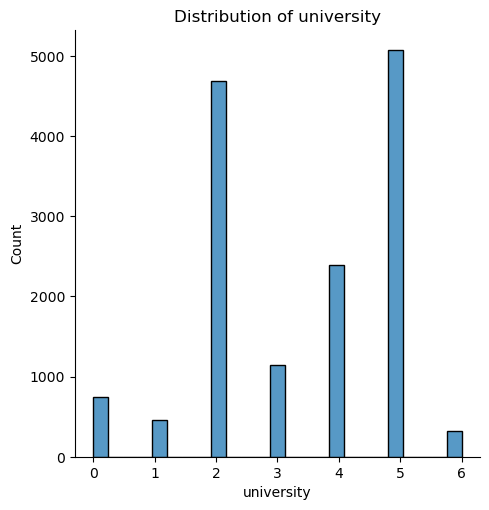

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


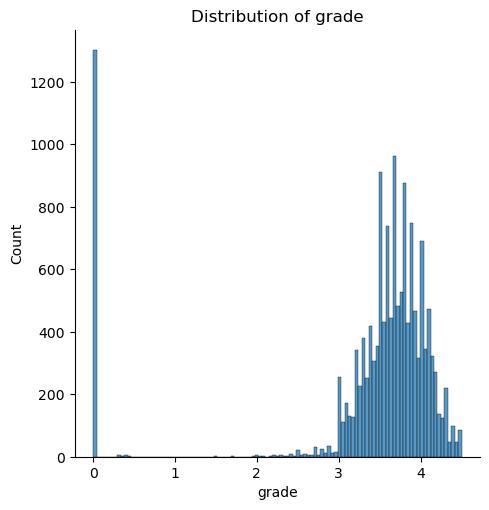

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


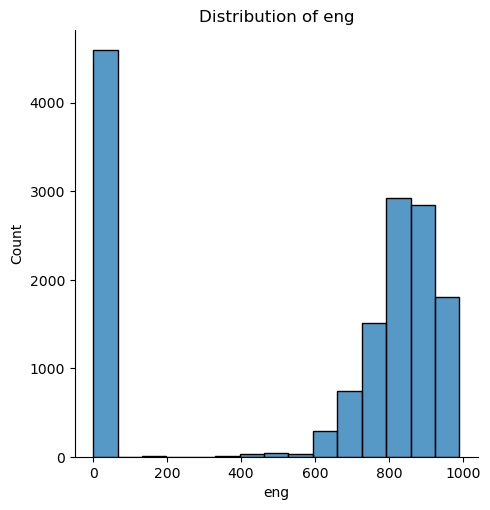

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


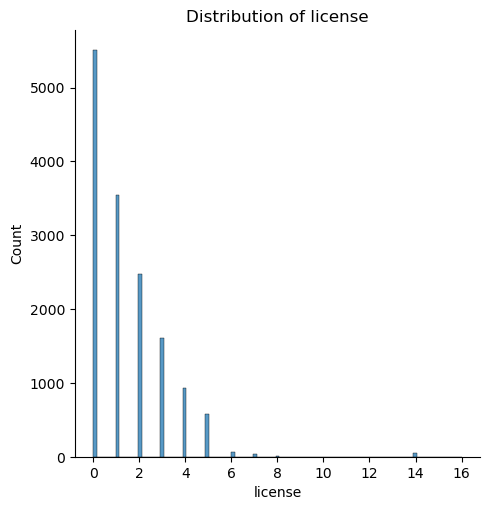

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


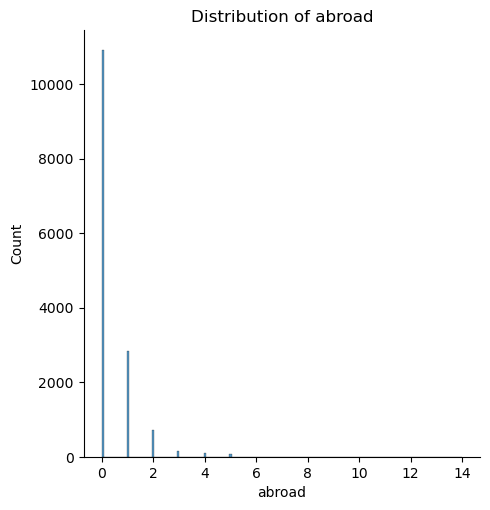

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


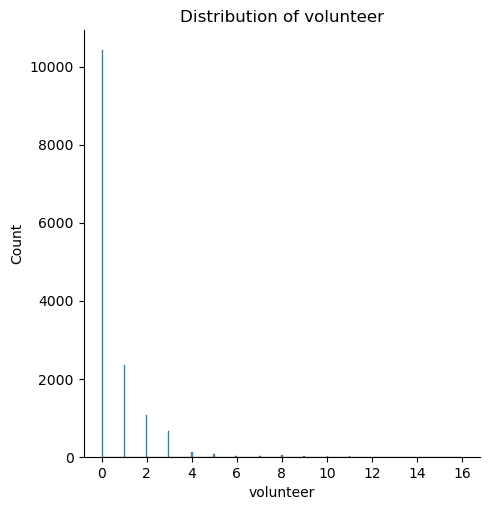

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


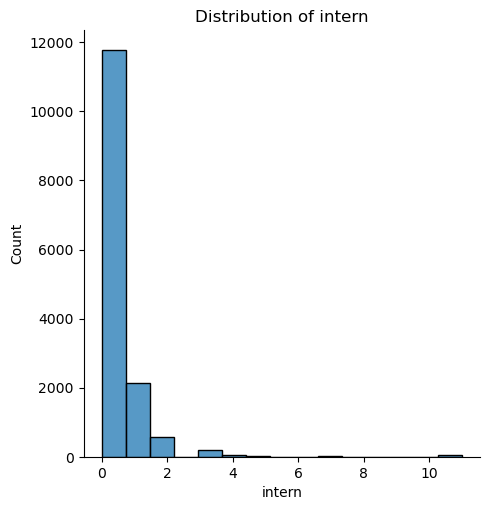

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


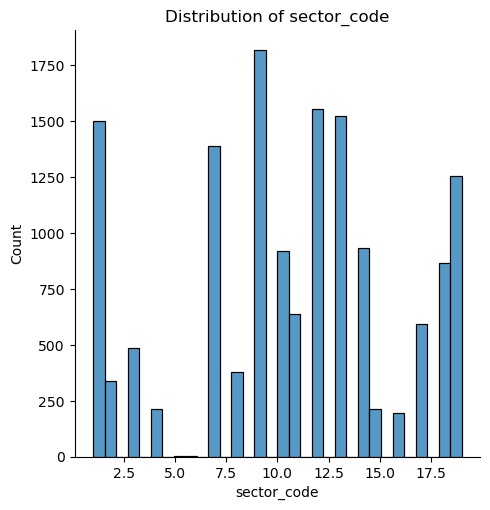

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


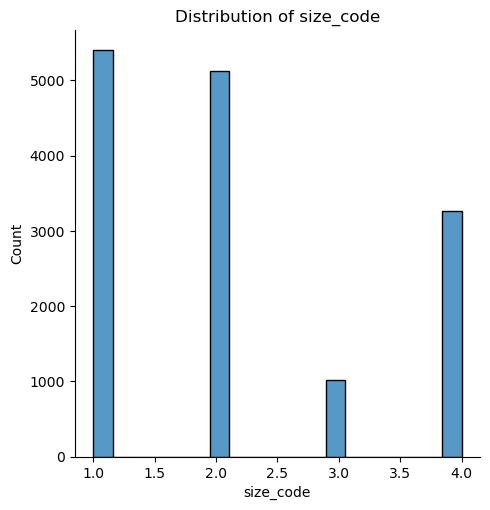

In [21]:
for column in df.columns:
    if df[column].dtype != 'object':
        sns.displot(df[column])
        plt.title(f'Distribution of {column}')
        plt.show()
        
# 학점을 보면 0값이 많은 것은 알 수 있다. 학점을 입력하지 않은경우 (고졸이거나~)
# 또한 0이 아닌 0과 1사이 소수점 값인 경우도 있는데, 이는 처리해야할 아웃라이어로 판단된다.

# 그외 해외연수, 인턴쉽, 수상경력등은 거의 0~1 근처에 분포해있으며, 일부 10회 이상이 기록되나 이상치로 보기는 힘듬
# 만일 머신러닝결과 학습이 잘 진행되지 않는다고 판단될 경우 추가적으로 제거. 현재는 문제 없을것으로 보임

# 영어점수의 경우 취합을 했음에도 0점에 분포해 있는 경우가 많음
# 이는 영어점수를 요구하는 기업이 아닐경우 영어점수를 따로 입력하지 않아 발생하는 문제로 판단됨
# 따라서 영어점수 0점은 중앙값으로 대체하는 식으로 이상치를 처리하고자 함

array([[<Axes: title={'center': 'university'}>,
        <Axes: title={'center': 'grade'}>,
        <Axes: title={'center': 'eng'}>],
       [<Axes: title={'center': 'license'}>,
        <Axes: title={'center': 'abroad'}>,
        <Axes: title={'center': 'volunteer'}>],
       [<Axes: title={'center': 'intern'}>,
        <Axes: title={'center': 'sector_code'}>,
        <Axes: title={'center': 'size_code'}>]], dtype=object)

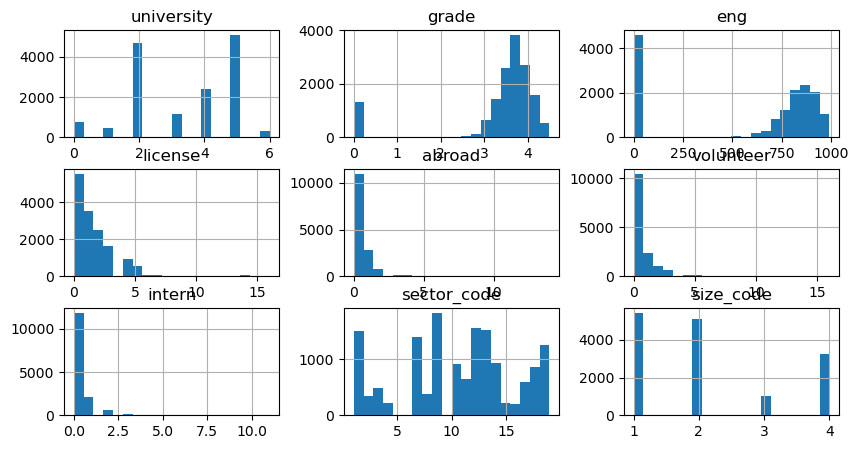

In [22]:
original_df = df
original_df.hist(bins=20, figsize=(10,5))

# 위 히스토그램 해석과 동일

#### 시각화 2 (박스 플롯)

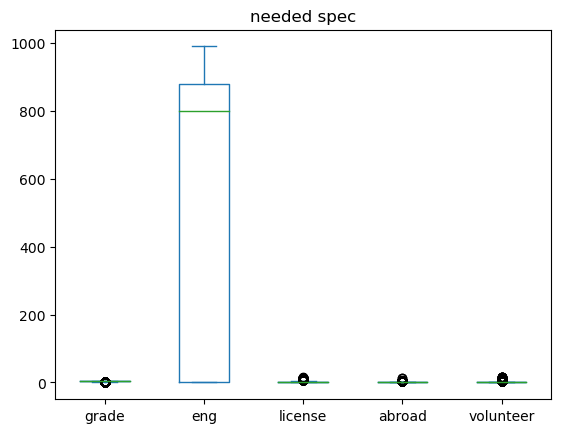

In [23]:
df.iloc[:,1:6].plot(kind = 'box');
plt.title ('needed spec')
plt.show();

# 박스플롯으로 출력한 결과 각각의 데이터 범주가 다르고
# 영어점수의 경우 특히 0~1000점 사이에 분포해 있기 때문에 식별을 위해선 minmaxscaler 등을 이용해 값 분포를 0~1사이에 일치시켜야 할 것으로 보임

# 단, 이때 labelencoder로 라벨링된 대학, 계열, 전공값은 정규화가 진행되지 않도록 주의!

#### 시각화 결과
- @ 데이터가 @한 부분이 이상해 처리가 필요하다. (처리해야하는 이유 설명)
- @ 데이터에서 아웃라이어가 많으나 이는 처리할 이상치가 아니라 판단된다.(처리해야하는 이유 설명)
- 따라서 @ 방법으로 처리하겠다.

#### ex) 학점 하위 25%가 3.4점인데 0점도 아니고 0.2~0.4점인 사람이 몇 있다
- 이상한게 맞는것 같으니 삭제 or 중앙값으로 대체하겠다.

#### ex) 봉사횟수 상위75%가 0회(1회)인데 11회인 사람이 있다
- 실제로 그런사람이 있을 수 있으니 오류값이 아니라 판단되어 그대로 두겠다
    - or 실제로 그렇다 하더라도 머신러닝에서 과적합/과소적합을 일으킬 요소로 보인다. 따라서 삭제한다.

#### 추가적인 데이터 EDA 진행

In [24]:
# 1. 학점 이상치 처리

df.loc[df['grade']<1,'grade'] = df['grade'].median()

In [25]:
# 2. 영어 이상치 처리
df.loc[df['eng']<100,'eng'] = df['eng'].median()

array([[<Axes: title={'center': 'university'}>,
        <Axes: title={'center': 'grade'}>,
        <Axes: title={'center': 'eng'}>],
       [<Axes: title={'center': 'license'}>,
        <Axes: title={'center': 'abroad'}>,
        <Axes: title={'center': 'volunteer'}>],
       [<Axes: title={'center': 'intern'}>,
        <Axes: title={'center': 'sector_code'}>,
        <Axes: title={'center': 'size_code'}>]], dtype=object)

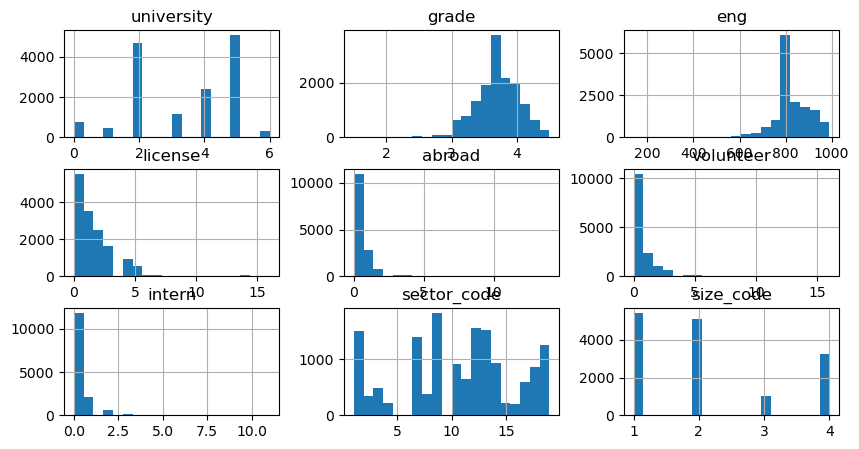

In [26]:
original_df = df
original_df.hist(bins=20, figsize=(10,5))

# 학점과 영어의 이상치가 성공적으로 사라진것을 확인할 수 있다.
# 단 영어점수를 하나로 통일할 때 토익스피킹과 오픽을 레벨에따라 특정값을 부여했더니
# 토익의 평탄화된 정규분포와 합쳐져 중간중간 삐죽삐죽 튀어나오는것을 확인할 수 있다.
# 분석해보고 값이 이상하다면 추가적인 평탄화 작업이 필요할 수 있다.

In [27]:
df.head()

,university,grade,eng,license,abroad,volunteer,intern,sector,sector_code,size,size_code
0,4,3.50,800,0,1,0,0,음식료/호텔/리조트/여행,10,중견기업,2
1,3,3.57,900,4,2,0,0,음식료/호텔/리조트/여행,10,중견기업,2
2,1,4.19,800,4,1,0,1,음식료/호텔/리조트/여행,10,중견기업,2
3,1,4.19,800,4,1,0,1,음식료/호텔/리조트/여행,10,중견기업,2
4,3,3.63,950,1,1,3,2,음식료/호텔/리조트/여행,10,중견기업,2


In [28]:
# 지나치게 작은 그룹은 삭제하려했으나

## 어차피 주제에서 분야별- 기업규모별 분류에서 기업규모별로만 분류한다면 굳이 지울 필요는 없을듯합니다.
df.groupby("sector").size()

sector
건설/엔지니어링         1501
광고/미디어/교육         339
다업종기업/기타          484
도매/소매             212
병원                  2
부동산                 3
상사/유통/운송         1390
섬유/패션             377
은행/증권/보험         1817
음식료/호텔/리조트/여행     921
의약/화장품/생활화학       639
자동차/기계/조선        1556
전자/전기            1522
정부/공공기관           931
제조                211
제지/가구/기타소비재       194
제철/금속/비금속재료       593
통신/IT             864
화학/정유/에너지        1254
dtype: int64

In [29]:
#df=df[df.sector != '병원']
#df=df[df.sector != '부동산']
df.groupby("sector").size()

sector
건설/엔지니어링         1501
광고/미디어/교육         339
다업종기업/기타          484
도매/소매             212
병원                  2
부동산                 3
상사/유통/운송         1390
섬유/패션             377
은행/증권/보험         1817
음식료/호텔/리조트/여행     921
의약/화장품/생활화학       639
자동차/기계/조선        1556
전자/전기            1522
정부/공공기관           931
제조                211
제지/가구/기타소비재       194
제철/금속/비금속재료       593
통신/IT             864
화학/정유/에너지        1254
dtype: int64

In [30]:
df.groupby("size").size()

size
공기업      958
대기업     5399
중견기업    5191
중소기업    3262
dtype: int64

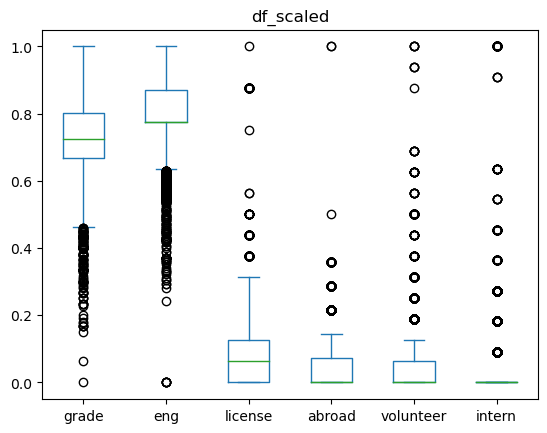

In [31]:
# 박스플롯으로 보기 위해 minmaxscaling을 진행한다.

from sklearn.preprocessing import MinMaxScaler
mms =  MinMaxScaler()
df_scaled =  mms.fit_transform(df.iloc[:,1:7])
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns =['grade' , 'eng','license','abroad','volunteer','intern']
df_scaled.plot(kind = 'box');
plt.title ('df_scaled')
plt.show();

# 진행 결과 아웃라이어가 굉장히 많은 것을 볼 수 있다 (아웃라이어 = 이상치 = 박스플롯 범위 바깥의 원들)
# 다만 히스토그램으로 확인해본 결과 값이 크게 이상하고 빈도수가 높은것은 아니라고 생각되므로 분석을 우선적으로 진행해보도록 하겠다.

In [32]:
df.head(2)

,university,grade,eng,license,abroad,volunteer,intern,sector,sector_code,size,size_code
0,4,3.50,800,0,1,0,0,음식료/호텔/리조트/여행,10,중견기업,2
1,3,3.57,900,4,2,0,0,음식료/호텔/리조트/여행,10,중견기업,2


In [33]:
df_scaled.head(2)

,grade,eng,license,abroad,volunteer,intern
0,0.666667,0.776471,0.00,0.071429,0.0,0.0
1,0.690000,0.894118,0.25,0.142857,0.0,0.0


In [34]:
df.iloc[:,1:7]=df_scaled.iloc[:,0:6]

In [35]:
df.head(2)

,university,grade,eng,license,abroad,volunteer,intern,sector,sector_code,size,size_code
0,4,0.666667,0.776471,0.00,0.071429,0.0,0.0,음식료/호텔/리조트/여행,10,중견기업,2
1,3,0.690000,0.894118,0.25,0.142857,0.0,0.0,음식료/호텔/리조트/여행,10,중견기업,2


#### 추가 EDA 진행 2 [15]ML 참고

In [36]:
def  std_exclude(df):
    columns  =  df [['grade' , 'eng','license','abroad','volunteer','intern']].columns     
    for col in columns:
        mean = df[col].mean();
        std  = df[col].std(); 
        b = np.abs(df[col]-mean) / std
        df = df[(b < 2 )]     
    return df 
df_scaled_fixed = std_exclude(df)


In [37]:
df_scaled_fixed

,university,grade,eng,license,abroad,volunteer,intern,sector,sector_code,size,size_code
0,4,0.666667,0.776471,0.0000,0.071429,0.0000,0.000000,음식료/호텔/리조트/여행,10,중견기업,2
2,1,0.896667,0.776471,0.2500,0.071429,0.0000,0.090909,음식료/호텔/리조트/여행,10,중견기업,2
3,1,0.896667,0.776471,0.2500,0.071429,0.0000,0.090909,음식료/호텔/리조트/여행,10,중견기업,2
6,2,0.666667,0.941176,0.0625,0.000000,0.0625,0.000000,음식료/호텔/리조트/여행,10,중견기업,2
7,3,0.756667,0.652941,0.1250,0.000000,0.0000,0.000000,음식료/호텔/리조트/여행,10,중견기업,2
...,...,...,...,...,...,...,...,...,...,...,...
14805,5,0.666667,0.776471,0.0000,0.000000,0.0000,0.000000,도매/소매,4,중소기업,4
14806,2,0.603333,0.776471,0.0000,0.071429,0.0000,0.000000,도매/소매,4,중소기업,4
14807,5,0.706667,0.776471,0.0000,0.000000,0.0000,0.000000,도매/소매,4,중소기업,4
14808,5,0.700000,0.776471,0.1250,0.000000,0.0000,0.000000,도매/소매,4,중소기업,4


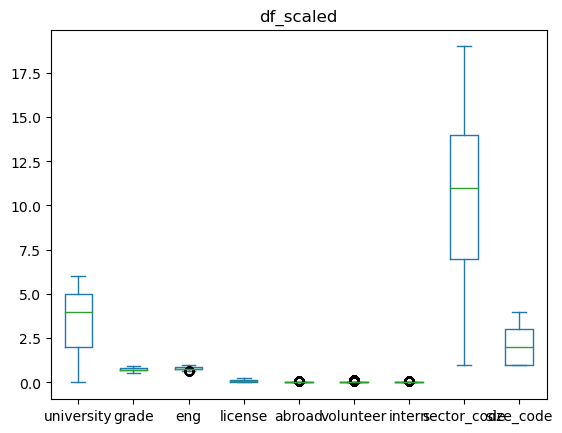

In [38]:
df_scaled_fixed.plot(kind = 'box');
plt.title ('df_scaled')
plt.show();

#### 시각화 3 ([8]ML_로지스틱회귀 참고)

In [39]:
# 이 그림 해석하려면 일단 코드 뜯어봐야겠는데 오늘 시간이없어서 거기까진 안될듯합니다.


#subset = df.iloc[:,8:]

#subset["MedHouseVal"] = pd.qcut(subset["MedHouseVal"], 6, retbins=False)    # 해석부탁요
#subset["MedHouseVal"] = subset["MedHouseVal"].apply(lambda x: x.mid)        # 22
#sns.pairplot(data=subset, hue="분석하고자 하는 값? 모르겠음. 일단 그림넣으려고 grade 넣고 돌렸습니다. ", palette="viridis")
#plt.savefig('plot01.png')

#### 시각화 4 상관관계 분석

<Axes: >

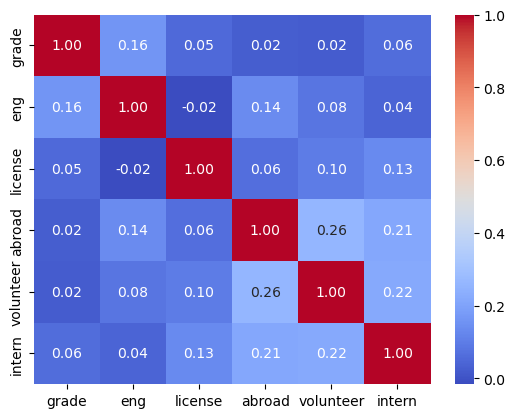

In [40]:
correlation_matrix = df_scaled_fixed.iloc[:,1:7].corr()

# Heatmap으로 상관 관계 시각화
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# 인턴과 봉사 상관관계가 있는것으로 나타나지만
# 대부분의 값이 0이었던 칼럼으로 그저 유사한 형태를 띄는것 판단됨

## 머신러닝 실행

In [41]:
df_scaled_fixed.head(2)

,university,grade,eng,license,abroad,volunteer,intern,sector,sector_code,size,size_code
0,4,0.666667,0.776471,0.00,0.071429,0.0,0.000000,음식료/호텔/리조트/여행,10,중견기업,2
2,1,0.896667,0.776471,0.25,0.071429,0.0,0.090909,음식료/호텔/리조트/여행,10,중견기업,2


In [42]:
df2 = df_scaled_fixed
df2['code'] = df2["sector"].map(str) + '-' +  df2["size"]
df2.head(2)

,university,grade,eng,license,abroad,volunteer,intern,sector,sector_code,size,size_code,code
0,4,0.666667,0.776471,0.00,0.071429,0.0,0.000000,음식료/호텔/리조트/여행,10,중견기업,2,음식료/호텔/리조트/여행-중견기업
2,1,0.896667,0.776471,0.25,0.071429,0.0,0.090909,음식료/호텔/리조트/여행,10,중견기업,2,음식료/호텔/리조트/여행-중견기업


In [43]:
X,y = df_scaled_fixed.iloc[:,:7], df2.iloc[:,-2] # df2.iloc[:,-1] 로 넣으면 기업분류별-기업규모별 분류가 됨
X.describe()

,university,grade,eng,license,abroad,volunteer,intern
count,10765.000000,10765.000000,10765.000000,10765.000000,10765.000000,10765.000000,10765.000000
mean,3.393683,0.734452,0.812403,0.072538,0.013702,0.016767,0.011713
std,1.597668,0.092689,0.073468,0.077060,0.028125,0.035153,0.030458
min,0.000000,0.513333,0.629412,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.670000,0.776471,0.000000,0.000000,0.000000,0.000000
50%,4.000000,0.723333,0.776471,0.062500,0.000000,0.000000,0.000000
75%,5.000000,0.800000,0.864706,0.125000,0.000000,0.000000,0.000000
max,6.000000,0.950000,0.988235,0.250000,0.071429,0.125000,0.090909


In [44]:
from sklearn.ensemble import RandomForestClassifier

# step 2. 학습 데이터와 검증 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# step 3. 모델 생성
model = RandomForestClassifier(max_depth=100, random_state=0)


# step 4. 학습
model.fit(X_train, y_train)


# step 5. 평가
pred  = model.predict(X_test)
print(accuracy_score(y_test,pred)) 
score =model.score(X_test,y_test)
print(f'평균정확도 = {score.mean():.5f}, 표준편차 = {score.std():.2f}')

0.42570579494799404
평균정확도 = 0.42571, 표준편차 = 0.00


In [45]:
# 분류 대상별 학습 크기가 랜덤
from sklearn.model_selection import cross_val_score,KFold

cv  = KFold(n_splits=10, shuffle=True, random_state=42)
results = cross_val_score(model, X_train, y_train,cv=cv)
fin_results =  np.mean(results)

type(results)

for i, _  in enumerate(results):
    print('{}번째 교차 검증 정확도 : {} '.format(i,_))
    

print(' 최종  교차 검증 정확도 : {} '.format(fin_results))

0번째 교차 검증 정확도 : 0.3997524752475248 
1번째 교차 검증 정확도 : 0.41955445544554454 
2번째 교차 검증 정확도 : 0.4034653465346535 
3번째 교차 검증 정확도 : 0.43866171003717475 
4번째 교차 검증 정확도 : 0.4052044609665427 
5번째 교차 검증 정확도 : 0.41511771995043373 
6번째 교차 검증 정확도 : 0.3915737298636927 
7번째 교차 검증 정확도 : 0.44114002478314746 
8번째 교차 검증 정확도 : 0.41759603469640644 
9번째 교차 검증 정확도 : 0.41511771995043373 
 최종  교차 검증 정확도 : 0.4147183677475554 


In [46]:
# 분류 대상별 학습 크기가 동일
from sklearn.model_selection import cross_val_score,StratifiedKFold

cv  = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results = cross_val_score(model, X_train, y_train,cv=cv)
fin_results =  np.mean(results)

type(results)

for i, _  in enumerate(results):
    print('{}번째 교차 검증 정확도 : {} '.format(i,_))
    

print(' 최종  교차 검증 정확도 : {} '.format(fin_results))

0번째 교차 검증 정확도 : 0.3873762376237624 
1번째 교차 검증 정확도 : 0.4344059405940594 
2번째 교차 검증 정확도 : 0.41089108910891087 
3번째 교차 검증 정확도 : 0.3878562577447336 
4번째 교차 검증 정확도 : 0.4275092936802974 
5번째 교차 검증 정확도 : 0.4225526641883519 
6번째 교차 검증 정확도 : 0.3667905824039653 
7번째 교차 검증 정확도 : 0.42874845105328374 
8번째 교차 검증 정확도 : 0.40148698884758366 
9번째 교차 검증 정확도 : 0.4473358116480793 
 최종  교차 검증 정확도 : 0.41149533168930275 


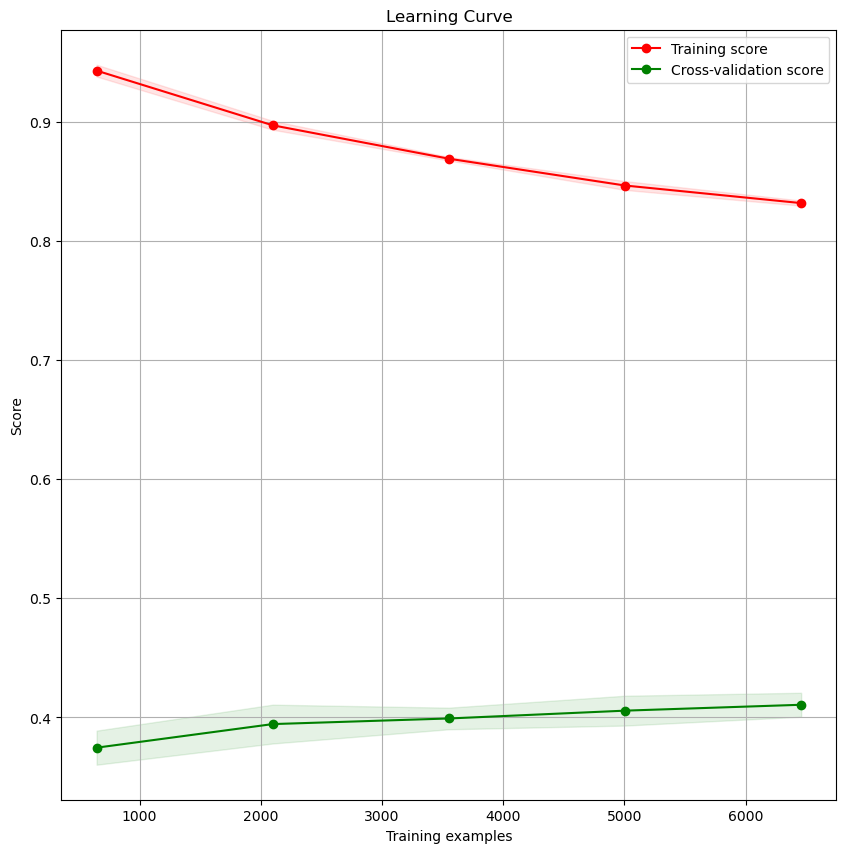

In [47]:
#!pip install scikit_plot
import scikitplot as skplt
skplt.estimators.plot_learning_curve(model, X_train, y_train,figsize=(10,10))
plt.show()

#### 세부 파라미터 조절 (GridSearchCV, RandomSearchCV)를 통해 수치 조절
- 또한 가능하다면, GridSearchCV, RandomSearchCV를 둘다 사용하고 둘중 무엇을 사용하는게 나은지도 설명
        - GridSearchCV는 모든 경우의 수를 고려하여 정확도는 높으나 실행 속도가 느림
        - RandomSearchCV는 일부만 뽑아 실행하여 실행속도가 빠름
        
        
        - ex) 우리가 나중에 목표로 하는건 많은 사람에게 빠른속도로 서비스를 제공하는 것이므로 Random쪽이 적합하다
        - ex) 우리가 최종적으로는 교육과정또한 추천하여 사람들이 적게는 1개월 많게는 6개월 이상의 시간을 투자하게 될텐데 오래걸려도 정확도가 높은쪽이 낫다고 판단된다.

In [48]:
# 4. 하이퍼 파라미터 그리드 설정 

param_grid = {
 'n_estimators': [5, 10, 100, 100],
 'criterion': ['gini', 'entropy', 'log_loss'], # 커널 함수의 폭 조절 -> 과소적합, 과대적합 발생하므로 교차검증 최적화
 'max_depth': [10, 100, 1000],
 'min_samples_split' : [2, 5, 10, 50, 100]
}

In [49]:
model = RandomForestClassifier()

In [50]:
# 5. GridSearchCV 설정하고 탐색 수행
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv = 5)
# 6. 수행
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [10, 100, 1000],
                         'min_samples_split': [2, 5, 10, 50, 100],
                         'n_estimators': [5, 10, 100, 100]})

In [51]:
# 7. 결과 출력(best_param, best_score)
print( "최적의 모델  :  "  , grid_search.best_estimator_)
print( "최적의 파람  :  "  , grid_search.best_params_)
print( "최적의 점수  :  "  , grid_search.best_score_)

최적의 모델  :   RandomForestClassifier(criterion='log_loss', max_depth=1000,
                       min_samples_split=50)
최적의 파람  :   {'criterion': 'log_loss', 'max_depth': 1000, 'min_samples_split': 50, 'n_estimators': 100}
최적의 점수  :   0.4430794787098953


In [54]:
# RandomizedSearchCV 작성
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
 'n_estimators': [5, 10, 100, 100],
 'criterion': ['gini', 'entropy', 'log_loss'], 
 'max_depth': [10, 100, 1000],
 'min_samples_split' : [2, 5, 10, 50, 100]
}

random_search= RandomizedSearchCV(model, param_grid,n_iter = 100, cv = 5, random_state = 2)
random_search.fit(X_train, y_train)
print( "최적의 모델  :  "  , random_search.best_estimator_)
print( "최적의 파람  :  "  , random_search.best_params_)
print( "최적의 점수  :  "  , random_search.best_score_)

최적의 모델  :   RandomForestClassifier(criterion='log_loss', max_depth=10, min_samples_split=5)
최적의 파람  :   {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 10, 'criterion': 'log_loss'}
최적의 점수  :   0.4429576346288858


## 앙상블
#### 각자 진행한 모델학습 취합

##  평가 (RUC/ 커브 그려서 정확도가 얼마나 되는지)
### [11]ML 참고

In [55]:
from sklearn.metrics import accuracy_score

pred = random_search.predict(X_test)
acc = accuracy_score(y_test, pred)
print('Accuracy :',acc)

Accuracy : 0.449851411589896


In [56]:
from sklearn.metrics import confusion_matrix
pred = random_search.predict(X_test)

#실제, 예측
cm =confusion_matrix(y_test, pred) 
print('confusion_matrix :\n\n' , cm )

confusion_matrix :

 [[686 278   1  22]
 [433 472   3  39]
 [101  66  18   9]
 [227 300   2  35]]


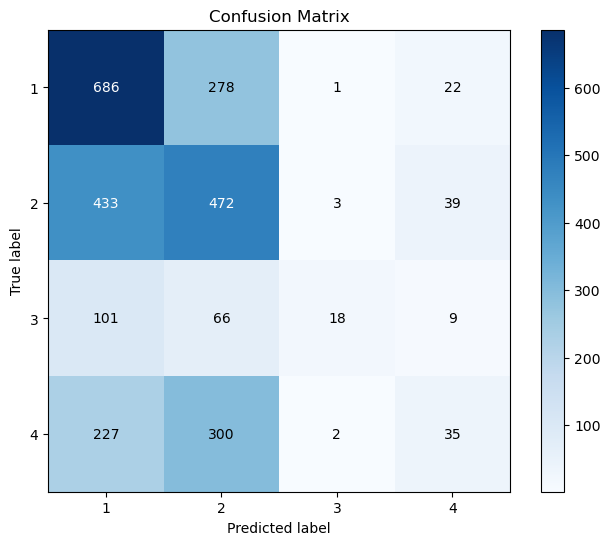

In [57]:
skplt.metrics.plot_confusion_matrix(y_test, pred, figsize = (8,6)) 
plt.show()

In [59]:
#4-1 정밀도 구하기 
# 다중분류일 경우에는 average= None 
# 기본값은  average= binary 
from sklearn.metrics import precision_score 

pre  = precision_score( y_test, random_search.predict(X_test) , average= None)

for target,score  in zip(['대기업', '중견기업', '공기업', '중소기업'], pre):
    print(f"{target}의 정밀도 : {score}")


대기업의 정밀도 : 0.47408431237042153
중견기업의 정밀도 : 0.4229390681003584
공기업의 정밀도 : 0.75
중소기업의 정밀도 : 0.3333333333333333


In [60]:
#4-2 재현율을 구하자.  recall_score: 실제 타켓 클래스 중에 예측이 맞는 비율이다. = 민감도  
 #tp / (tp + fn)
from sklearn.metrics import recall_score

recall  = recall_score( y_test, random_search.predict(X_test) , average= None)

for target,score  in zip(['대기업', '중견기업', '공기업', '중소기업'], recall):
    print(f"{target}의 재현률 : {score}")

대기업의 재현률 : 0.6950354609929078
중견기업의 재현률 : 0.498416050686378
공기업의 재현률 : 0.09278350515463918
중소기업의 재현률 : 0.06205673758865248


In [61]:

from sklearn.metrics import f1_score

f1  = f1_score( y_test, random_search.predict(X_test) , average= None)

for target,score  in zip(['대기업', '중견기업', '공기업', '중소기업'], f1):
    print(f"{target}의 F : {score}")

대기업의 F : 0.5636811832374692
중견기업의 F : 0.45758603974793993
공기업의 F : 0.1651376146788991
중소기업의 F : 0.10463378176382661


In [62]:
 # 각 클래스에 대한 확률/ 클래스에  대한 출력은 0과 1사이의 값 , 클래스의 합은  1이다.
proba =random_search.predict_proba(X_test) 
print("확률 값의 형태: {}".format(proba.shape)) 

#print(proba) #->예측확률

print("합: {}".format(random_search.predict_proba(X_test)[:5].sum(axis=1))) #행방향으로 합을 구하면 1이 된다.

#skplt.metrics.plot_roc(y_test,proba, figsize=(8,6))
#plt.show()

확률 값의 형태: (2692, 4)
합: [1. 1. 1. 1. 1.]


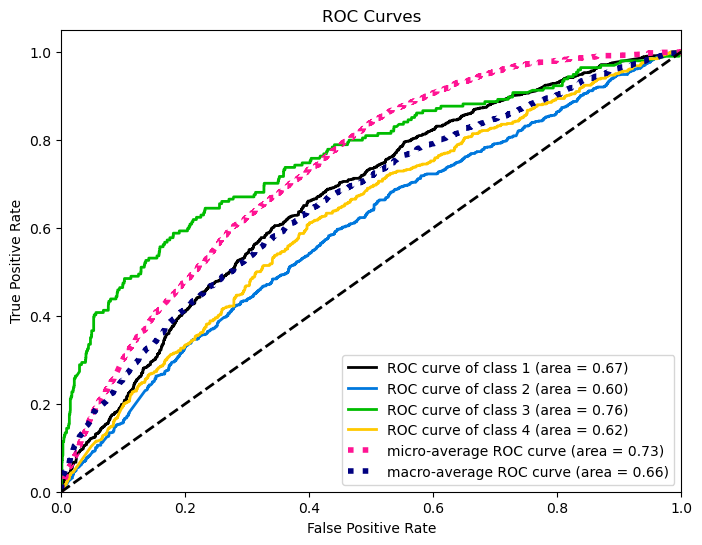

In [63]:
skplt.metrics.plot_roc(y_test,proba, figsize=(8,6))
plt.show()